# Pytorch Fuel Efficiency Predictor

## Using Linear Regression

### Import necessary libraries

In [31]:
import torch
from torch import nn

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Prepare the data

In [32]:
# Load in the csv with the dataset
df = pd.read_csv("2014-2024_Fuel_Efficiency_Canada.csv")

# Extract the features (X) from the dataset
X  = df[["Model year", "Make", "Model", "Vehicle class", "Engine size (L)", "Cylinders", "Transmission", "Fuel type"]].copy()

# Extract the labels (Y) from the dataset
Y = df[["Combined (L/100 km)"]].copy()

# Preview the features
X.head()

,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type
0,2015,Acura,ILX,Compact,2.0,4,AS5,Z
1,2015,Acura,ILX,Compact,2.4,4,M6,Z
2,2015,Acura,ILX Hybrid,Compact,1.5,4,AV7,Z
3,2015,Acura,MDX SH-AWD,Sport utility vehicle: Small,3.5,6,AS6,Z
4,2015,Acura,RDX AWD,Sport utility vehicle: Small,3.5,6,AS6,Z


In [33]:
# Encode all the non-numeric features to numeric values
categories = ["Make", "Model", "Vehicle class", "Transmission", "Fuel type"]
label_encoders = {}

for category in categories:
    label_encoder = LabelEncoder()
    X[category] = label_encoder.fit_transform(X[category])
    label_encoders[category] = label_encoder

# Preview the features
X.head()

,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type
0,2015,0,1044,0,2.0,4,14,4
1,2015,0,1044,0,2.4,4,26,4
2,2015,0,1045,0,1.5,4,23,4
3,2015,0,1206,8,3.5,6,15,4
4,2015,0,1459,8,3.5,6,15,4


In [ ]:
# Convert X and Y into tensors
X = torch.tensor(X.values, dtype=torch.float32)
Y = torch.tensor(Y.values, dtype=torch.float32)

# Split the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    train_size=0.8,
                                                    random_state=2)

# Check the shapes of all the tensors
X_train.shape, X_test.shape, Y_test.shape, Y_test.shape

(torch.Size([8046, 8]),
 torch.Size([2012, 8]),
 torch.Size([2012, 1]),
 torch.Size([2012, 1]))

### Build the Model

In [35]:
# Create a linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=8,
                                      out_features=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set a manual seed for reproducability
torch.manual_seed(2)

# Create an instance of the model and view the state_dict 
model = LinearRegressionModel()
model, model.state_dict() # all values are random before being trained

(LinearRegressionModel(
   (linear_layer): Linear(in_features=8, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight',
               tensor([[ 0.0811, -0.0841,  0.0970, -0.0181,  0.1510,  0.0842, -0.0406, -0.2858]])),
              ('linear_layer.bias', tensor([0.0807]))]))

### Training the Model

In [36]:
# Create loss function
loss_fn = nn.MSELoss()

# Create optimizer
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.01)

In [37]:
# Set a manual seed for reproducability
torch.manual_seed(2)

# Set the epochs
epochs = 100

# Training loop
for epoch in range(epochs+1):
    # Training
    model.train()

    # Forward pass
    Y_pred = model(X_train)

    # Calculate loss
    loss = loss_fn(Y_pred, Y_train)

    # Zero grad optimizer
    optimizer.zero_grad()

    # Loss backwards
    loss.backward()

    # Step the optimizer
    optimizer.step()

    # Testing
    model.eval()
    # Forward pass
    with torch.inference_mode():
        test_pred = model(X_test)

        # Calculate the loss
        test_loss = loss_fn(test_pred, Y_test)
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 65478.0546875 | Test loss: 50251.25390625
Epoch: 10 | Train loss: 637.8906860351562 | Test loss: 1778.0345458984375
Epoch: 20 | Train loss: 4083.892578125 | Test loss: 3075.462890625
Epoch: 30 | Train loss: 655.7742919921875 | Test loss: 880.2120971679688
Epoch: 40 | Train loss: 230.60997009277344 | Test loss: 114.40841674804688
Epoch: 50 | Train loss: 247.8460693359375 | Test loss: 229.7648162841797
Epoch: 60 | Train loss: 26.44120979309082 | Test loss: 38.578468322753906
Epoch: 70 | Train loss: 18.16029167175293 | Test loss: 12.608866691589355
Epoch: 80 | Train loss: 19.992338180541992 | Test loss: 17.627553939819336
Epoch: 90 | Train loss: 11.84837532043457 | Test loss: 12.077127456665039
Epoch: 100 | Train loss: 8.984942436218262 | Test loss: 9.191866874694824


In [38]:
# Find our models learned parameters
print("The model learned the following values for weights and biases:")
print(model.state_dict())

The model learned the following values for weights and biases:
OrderedDict({'linear_layer.weight': tensor([[ 8.0537e-03, -1.4450e-01, -1.0307e-04, -8.7418e-02,  8.6268e-02,
          1.7928e-02, -1.1038e-01, -3.5545e-01]]), 'linear_layer.bias': tensor([0.0077])})


In [39]:
# Turn the model into eval mode
model.eval()

# Make predictions on the test data
with torch.inference_mode():
    Y_preds = model(X_test)

# Print predictions and calulate error
total_error = 0

for index in range(len(Y_preds)):
    total_error += abs(Y_preds[index] - Y_test[index])
    print(f"The model predicted a fuel efficiency of {Y_preds[index][0]:.4f} vs a true value of {Y_test[index][0]:.4f} L/100km\n")

avg_error = total_error / len(Y_preds)

print("--------------------------------------------")
print(f"On average the model was off by {avg_error[0]:.6f}")

The model predicted a fuel efficiency of 9.7295 vs a true value of 8.4000 L/100km

The model predicted a fuel efficiency of 10.8458 vs a true value of 9.2000 L/100km

The model predicted a fuel efficiency of 11.5053 vs a true value of 7.8000 L/100km

The model predicted a fuel efficiency of 9.9924 vs a true value of 11.2000 L/100km

The model predicted a fuel efficiency of 7.3413 vs a true value of 9.9000 L/100km

The model predicted a fuel efficiency of 12.5516 vs a true value of 10.3000 L/100km

The model predicted a fuel efficiency of 9.2386 vs a true value of 11.3000 L/100km

The model predicted a fuel efficiency of 6.3183 vs a true value of 10.5000 L/100km

The model predicted a fuel efficiency of 13.5852 vs a true value of 9.6000 L/100km

The model predicted a fuel efficiency of 7.6908 vs a true value of 5.1000 L/100km

The model predicted a fuel efficiency of 7.7321 vs a true value of 11.1000 L/100km

The model predicted a fuel efficiency of 7.9693 vs a true value of 8.7000 L/10

## Using a Neural Network

### Build the Model

In [ ]:
# 3 Layer deep neural network
# - 1 input layer with 8 neurons
# - 1 deep layer with 12 neurons
# - 1 output later with 1 neuron

#  Create the neural network model
class NNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer_1 = nn.Linear(in_features=8,
                                        out_features=12)
        self.linear_layer_2 = nn.Linear(in_features=12,
                                        out_features=12)
        self.linear_layer_3 = nn.Linear(in_features=12,
                                        out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.linear_layer_1(x))
        x = self.relu(self.linear_layer_2(x))
        x = self.linear_layer_3(x)
        return x

# Set random seed for reproducability
torch.manual_seed(2)

# Create an instance of the model and view the state_dict
model = NNModel()
model, model.state_dict()

(NNModel(
   (linear_layer_1): Linear(in_features=8, out_features=12, bias=True)
   (linear_layer_2): Linear(in_features=12, out_features=12, bias=True)
   (linear_layer_3): Linear(in_features=12, out_features=1, bias=True)
   (relu): ReLU()
 ),
 OrderedDict([('linear_layer_1.weight',
               tensor([[ 0.0811, -0.0841,  0.0970, -0.0181,  0.1510,  0.0842, -0.0406, -0.2858],
                       [ 0.0807, -0.3130,  0.0465,  0.0235, -0.0777,  0.2891,  0.0236,  0.1466],
                       [ 0.1496, -0.2086, -0.1359,  0.3400, -0.3463, -0.0240, -0.0280,  0.2508],
                       [-0.0336,  0.0931, -0.0170, -0.1980, -0.2004, -0.1718, -0.3212, -0.2294],
                       [ 0.0832,  0.2327,  0.0174, -0.1621,  0.1554, -0.1357, -0.0783, -0.1938],
                       [-0.1110, -0.3276,  0.1509,  0.1375,  0.0702,  0.1736,  0.1498,  0.0156],
                       [ 0.0374,  0.0270,  0.1887,  0.2375,  0.2539,  0.2049, -0.0862, -0.0157],
                       [-0.0718,  0

### Training the Model

In [41]:
# Create the loss function
loss_fn = nn.MSELoss()

# Create the optimizer
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.01)

In [42]:
# Set the manual seed for reproducability
torch.manual_seed(2)

# Set the epochs
epochs = 1000

# To graph training progress
train_losses = []
test_losses = []

for epoch in range(epochs+1):
    # Training
    model.train()

    # Forward pass
    Y_pred = model(X_train)

    # Calculate loss
    loss = loss_fn(Y_pred, Y_train)

    # Zero grad optimizer
    optimizer.zero_grad()

    # Loss backwards
    loss.backward()

    # Step the optimizer
    optimizer.step()

    # Testing
    model.eval()
    # Forward pass
    with torch.inference_mode():
        test_pred = model(X_test)

        # Calculate the loss
        test_loss = loss_fn(test_pred, Y_test)
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")
        train_losses.append(loss.item())
        test_losses.append(test_loss.item())

Epoch: 0 | Train loss: 27.03183364868164 | Test loss: 14.963384628295898
Epoch: 10 | Train loss: 9.839421272277832 | Test loss: 8.848536491394043


Epoch: 20 | Train loss: 7.7479472160339355 | Test loss: 7.357655048370361
Epoch: 30 | Train loss: 7.68873405456543 | Test loss: 7.253964424133301
Epoch: 40 | Train loss: 7.524172306060791 | Test loss: 7.128489017486572
Epoch: 50 | Train loss: 7.398934364318848 | Test loss: 7.010423183441162
Epoch: 60 | Train loss: 7.263556480407715 | Test loss: 6.882466793060303
Epoch: 70 | Train loss: 7.105823993682861 | Test loss: 6.737186431884766
Epoch: 80 | Train loss: 6.919057846069336 | Test loss: 6.562808990478516
Epoch: 90 | Train loss: 6.688307285308838 | Test loss: 6.347366809844971
Epoch: 100 | Train loss: 6.405594825744629 | Test loss: 6.086038589477539
Epoch: 110 | Train loss: 6.073404312133789 | Test loss: 5.782167911529541
Epoch: 120 | Train loss: 5.71328592300415 | Test loss: 5.456817150115967
Epoch: 130 | Train loss: 5.34805154800415 | Test loss: 5.1264967918396
Epoch: 140 | Train loss: 4.972842693328857 | Test loss: 4.787721157073975
Epoch: 150 | Train loss: 7.031773567199707 | Test 

In [43]:
# Find our models learned parameters
print("The model learned the following values for weights and biases:")
print(model.state_dict())

The model learned the following values for weights and biases:
OrderedDict({'linear_layer_1.weight': tensor([[ 0.1506, -0.0739,  0.0928, -0.5831, -3.0421, -2.4929,  0.1810,  0.3176],
        [ 0.0274, -0.4410, -0.0048,  0.0221, -2.8912, -1.8174, -0.2083,  0.7867],
        [ 0.1381, -0.1930, -0.1222,  0.4065,  1.8618,  1.6238, -0.0200, -0.3458],
        [-0.0336,  0.0931, -0.0170, -0.1980, -0.2004, -0.1718, -0.3212, -0.2294],
        [ 0.0749,  0.1646, -0.0251, -0.4510, -2.7901, -2.4540,  0.0395,  0.3714],
        [-0.1748, -0.3902,  0.0869,  0.0725,  0.0038,  0.1079,  0.0881, -0.0478],
        [-0.0120,  0.6382,  0.0900,  0.3117, -1.6427, -1.1725, -0.2779,  0.6594],
        [-0.0718,  0.2057,  0.0393,  0.3272,  0.1793, -0.3022,  0.1034,  0.3397],
        [ 0.2886, -0.0244,  0.1341,  0.0153,  2.6562,  2.3816, -0.5130, -0.2636],
        [-0.2325,  0.1118, -0.0134,  0.0623,  0.0343, -0.3305, -0.0759, -0.2235],
        [ 0.1757, -0.1215, -0.2624,  0.5759,  2.4353,  1.7931, -0.1828,  0.1107

### Make Predictions

In [44]:
# Turn the model into eval mode
model.eval()

# Make predictions on the test data
with torch.inference_mode():
    Y_preds = model(X_test)

# Print predictions and calulate error
total_error = 0

for index in range(len(Y_preds)):
    total_error += abs(Y_preds[index] - Y_test[index])
    print(f"The model predicted a fuel efficiency of {Y_preds[index][0]:.4f} vs a true value of {Y_test[index][0]:.4f} L/100km\n")

avg_error = total_error / len(Y_preds)

print("--------------------------------------------")
print(f"On average the model was off by {avg_error[0]:.6f}")

The model predicted a fuel efficiency of 8.6153 vs a true value of 8.4000 L/100km

The model predicted a fuel efficiency of 9.2046 vs a true value of 9.2000 L/100km

The model predicted a fuel efficiency of 8.2330 vs a true value of 7.8000 L/100km

The model predicted a fuel efficiency of 13.2350 vs a true value of 11.2000 L/100km

The model predicted a fuel efficiency of 9.5796 vs a true value of 9.9000 L/100km

The model predicted a fuel efficiency of 8.8520 vs a true value of 10.3000 L/100km

The model predicted a fuel efficiency of 11.7928 vs a true value of 11.3000 L/100km

The model predicted a fuel efficiency of 9.4986 vs a true value of 10.5000 L/100km

The model predicted a fuel efficiency of 10.6914 vs a true value of 9.6000 L/100km

The model predicted a fuel efficiency of 9.2319 vs a true value of 5.1000 L/100km

The model predicted a fuel efficiency of 12.2544 vs a true value of 11.1000 L/100km

The model predicted a fuel efficiency of 8.6501 vs a true value of 8.7000 L/10

### Visualize

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000]


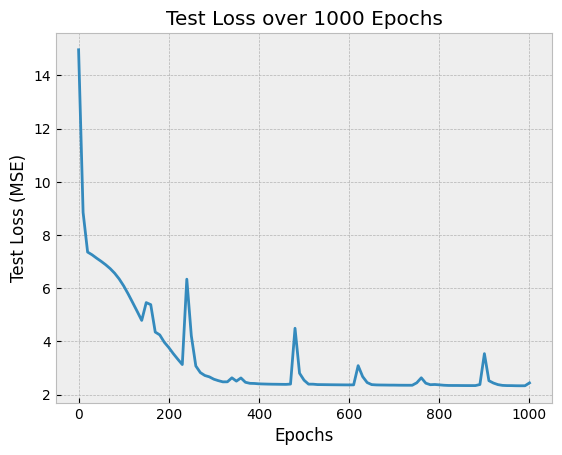

<Figure size 2000x1600 with 0 Axes>

In [46]:
# Plot test loss over the epochs
epochs = [x for x in range(0, 1001, 10)]
print(epochs)

plt.plot(epochs, test_losses)
plt.style.use("bmh")
plt.xlabel("Epochs")
plt.ylabel("Test Loss (MSE)")
plt.title("Test Loss over 1000 Epochs")
plt.figure(figsize=(5, 4), dpi=400)

plt.show()